# 1. GAIN train and test example
## 1.1. Import all needed packages

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from fireman_imputation.GAIN import GAIN_main
from fireman_imputation.GAIN import GAIN_netG_forward
from fireman_imputation.src import utils
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1.2. Main

### 1.2.1 Load the data

In [ ]:
# load and scale the data
data_orig = pd.read_csv('data/spam.csv',index_col=False)
data = data_orig.values

# scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(data)
data_scaled = scaler.transform(data)

# create missing data mask
data_scaled_missing, mask = utils.MCARgen(data_scaled, 0.2)

# divide the data to train/test
# by default shuffles data, if pandas is passed the index shows shuffle result
data_train, data_test, mask_train, mask_test = train_test_split(data_scaled, mask, train_size=0.9)

### 1.2.2 Define hyperparameters

In [8]:
# set hyper-parameters
gain_params = {'batch_size': 128,
               'hint_rate': 0.9,
               'alpha': 100,
               'epochs': 10,
               'learning_rate': 0.001,
               'checkpoint_dir': ''}

### 1.2.3 Run the training

In [9]:
# train the net
lossG_curr, lossD_curr, lossMSE_train_curr, netG, netD, rmse = GAIN_main(gain_params, data_train, mask_train, data_test, mask_test)

print('RMSE of test dataset is {}'.format(rmse))

RMSE of test dataset is 0.032986490417319124


## 1.3. Visualize imputed data

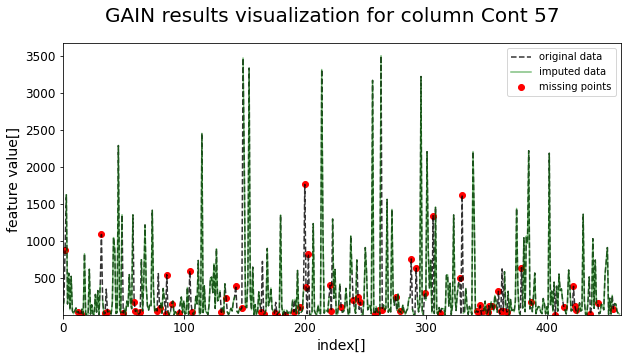

In [10]:
# impute test data
# use data_test as a "real-world" data with missing values
data_test_missing = data_test.copy()
data_test_missing[mask_test==0] = np.nan
data_test_imputed = GAIN_netG_forward(netG, data_test_missing)

# rescale the imputed and test data
data_test_rescaled = scaler.inverse_transform(data_test)
data_test_imputed_rescaled = scaler.inverse_transform(data_test_imputed)

# create pandas for easier visualization
data_test_pd = pd.DataFrame(data_test_rescaled, columns=data_orig.columns)
data_test_imputed_pd = pd.DataFrame(data_test_imputed_rescaled, columns=data_orig.columns)

# define which column we want to plot and plot the plots :)
column = 'Cont 57'
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
fig.suptitle('GAIN results visualization for column ' + column, size=20)

data_test_pd[column].plot(ax=ax, style='--', alpha=0.8, color='black', label='original data')
data_test_imputed_pd[column].plot(ax=ax, alpha=0.5, color='green', label='imputed data')

col_int = data_test_pd.columns.get_loc(column)
x = np.where(np.isnan(data_test_missing[:,col_int]))[0]
y = data_test_pd.iloc[x,col_int]
ax.scatter(x, y, color='red', label='missing points')
ax.set_xlim([0,len(data_test_imputed_pd)])
ax.set_ylim([data_test_imputed_pd[column].min()*0.95,data_test_imputed_pd[column].max()*1.05])
ax.tick_params(labelsize=12)
ax.set_xlabel('index[]',size=14)
ax.set_ylabel('feature value[]',size=14)

ax.legend();

In [1]:
from fireman_imputation.src.utils import HINTmatrix_gen, MCARgen
import numpy as np
import torch

In [26]:
def test_MCARgen_HINTmatrix():
    p = 0.2
    data = np.random.uniform(0,10,size=[1000,1000])
    data_missing, mask = MCARgen(data, probability=p)
    hint_matrix = HINTmatrix_gen(torch.from_numpy(mask), hint_rate=(1-p), orig_paper=False).numpy()
    assert round(abs(hint_matrix-mask).sum()/(mask.shape[0]*mask.shape[1]), 1) == p
test_MCARgen_HINTmatrix()